### 0. Imports and requirements

* В данном соревновании мы имеем дело с последовательностями, один из интуитивных способов работы с ними &ndash; использование рекуррентных нейронных сетей. В этом базовом решении мы демонстрируем, как можно построить хорошее решение задачи соревнования без использования сложного и трудоемкого feature engineering'а (чтобы эффективно решать ту же задачу с высоким качеством с помощью бустингов нужно несколько тысяч признаков), благодаря рекуррентным нейронным сетям. В этом ноутбуке мы построим решение с использованием фреймфорка `tensorflow`. Для комфортной работы Вам понадобится машина с `GPU` (хватит ресурсов `google colab` или `kaggle`).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
import tqdm

# !!! измените "2" на номер доступной вам сuda
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
pd.set_option('display.max_columns', None)

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

### 1. Data Preprocessing

In [3]:
TRAIN_DATA_PATH = "../data/train_data/"
TEST_DATA_PATH = "../data/test_data/"

TRAIN_TARGET_PATH = "../data/train_target.csv"

In [4]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


* Как и в случае с бустингами, мы не можем поместить всю выборку в память ввиду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отдельного внимания к тому, как будут предобработаны и поданы данные. Важные моменты, на которые требуется обратить внимание:
    1. Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность &ndash; все исторические кредиты клиента. Чтобы преобразовать `pd.DataFrame` с записями из кредитных историй клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_credits_to_sequences`, она производит необходимые манипуляции и возвращает фрейм с двумя колонками: `id` и `sequences`. Колонка `sequences` представляет из себя список списков длины `len(features)`, где каждый вложенный список &ndash; значения одного конкретного признака во всех кредитах клиента. 
    
    2. Клиенты могут иметь различные по длине кредитные истории. При этом обучение нейронных сетей происходит батчами и поскольку рекуррентные слои не способны обрабатывать батчи с последовательностями  неодинаковой длины, существует несколько подходов для приведения последовтельностей в батче к удобоваримому виду. Простой подход заключается в дополнении более коротких последовательностей нулями до максимальной длины последовательности в батче (т. н. паддинг). Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `Sequence Bucketing` (о ней мы рассказываем в нашем треке). Для реализации паддинга последовательностей кредитов клиентов мы подготовили функцию `dataset_preprocessing_utils.create_padded_buckets`.

In [5]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [6]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_0.pq
../data/train_data/train_data_1.pq
../data/train_data/train_data_2.pq
../data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_4.pq
../data/train_data/train_data_5.pq
../data/train_data/train_data_6.pq
../data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_8.pq
../data/train_data/train_data_9.pq
../data/train_data/train_data_10.pq
../data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
../data/test_data/test_data_0.pq
../data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 53.8 s, total: 1min 55s
Wall time: 53.5 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [7]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

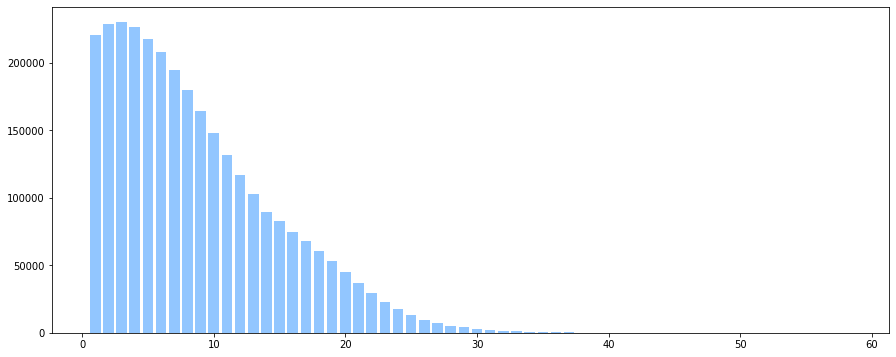

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

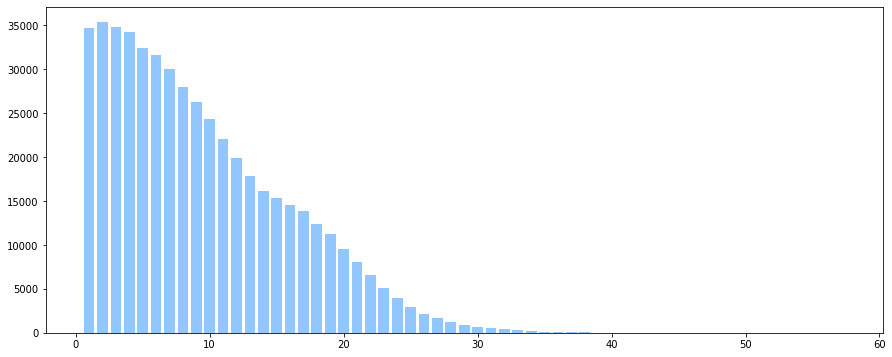

In [9]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [10]:
train_lens.max(), test_lens.max()

(58, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [11]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [12]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [13]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [14]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [15]:
TRAIN_BUCKETS_PATH = "../data/train_buckets_rnn"
VAL_BUCKETS_PATH = "../data/val_buckets_rnn"
TEST_BUCKETS_PATH = "../data/test_buckets_rnn"

In [16]:
for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    !rm -rf $buckets_path
    !mkdir $buckets_path

In [17]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=4, 
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_0.pq
../data/train_data/train_data_1.pq
../data/train_data/train_data_2.pq
../data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_4.pq
../data/train_data/train_data_5.pq
../data/train_data/train_data_6.pq
../data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_8.pq
../data/train_data/train_data_9.pq
../data/train_data/train_data_10.pq
../data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 13min 57s, sys: 2min 2s, total: 16min
Wall time: 15min 6s


['../data/train_buckets_rnn/processed_chunk_000.pkl',
 '../data/train_buckets_rnn/processed_chunk_001.pkl',
 '../data/train_buckets_rnn/processed_chunk_002.pkl']

In [18]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=4, 
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_0.pq
../data/train_data/train_data_1.pq
../data/train_data/train_data_2.pq
../data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_4.pq
../data/train_data/train_data_5.pq
../data/train_data/train_data_6.pq
../data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_8.pq
../data/train_data/train_data_9.pq
../data/train_data/train_data_10.pq
../data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 13min 37s, sys: 1min 34s, total: 15min 12s
Wall time: 14min 23s


['../data/val_buckets_rnn/processed_chunk_000.pkl',
 '../data/val_buckets_rnn/processed_chunk_001.pkl',
 '../data/val_buckets_rnn/processed_chunk_002.pkl']

In [19]:
%%time
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Preparing credit data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
../data/test_data/test_data_0.pq
../data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 2min 20s, sys: 20 s, total: 2min 40s
Wall time: 2min 29s


['../data/test_buckets_rnn/processed_chunk_000.pkl']

### 2. Modeling

* Для создания модели будем использовать фреймворк `tensorflow`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. 

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [21]:
from data_generators import batches_generator
from tf_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [22]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [23]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [24]:
def build_transactions_rnn(features, embedding_projections, 
                           rnn_units=128, classifier_units=32, optimizer=None):
    if not optimizer:
        optimizer = keras.optimizers.Adam(lr=1e-3)
        
    inputs = []
    cat_embeds = []
    
    for feature_name in features:
        inp = L.Input(shape=(None, ), dtype="uint32", name=f"input_{feature_name}")
        inputs.append(inp)
        source_size, projection = embedding_projections[feature_name]
        emb = L.Embedding(source_size+1, projection, trainable=True, mask_zero=False, name=f"embedding_{feature_name}")(inp)
        cat_embeds.append(emb)
    
    concated_cat_embeds = L.concatenate(cat_embeds)
    
    last_state = L.GRU(units=rnn_units)(concated_cat_embeds)
        
    dense_intermediate = L.Dense(classifier_units, activation="relu")(last_state)
    proba = L.Dense(1, activation="sigmoid")(dense_intermediate)
    
    model = Model(inputs=inputs, outputs=proba)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model

### 3. Training

In [25]:
!rm -rf ./checkpoints/
!mkdir ./checkpoints/

In [26]:
!rm -r ./checkpoints/tf_baseline
!mkdir ./checkpoints/tf_baseline

rm: cannot remove ‘./checkpoints/tf_baseline’: No such file or directory


* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [27]:
path_to_checkpoints = "./checkpoints/tf_baseline/"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"), 
                   metric_name="ROC-AUC", save_format="tf")

In [28]:
num_epochs = 10
train_batch_size = 128
val_batch_szie = 128

In [30]:
model = build_transactions_rnn(features, embedding_projections)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_pre_since_opened (InputLa [(None, None)]       0                                            
__________________________________________________________________________________________________
input_pre_since_confirmed (Inpu [(None, None)]       0                                            
__________________________________________________________________________________________________
input_pre_pterm (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_pre_fterm (InputLayer)    [(None, None)]       0                                            
____________________________________________________________________________________________

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [32]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, dataset_train, batch_size=train_batch_size, 
                shuffle=True, cur_epoch=epoch, steps_per_epoch=21160)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_szie)
    es(val_roc_auc, model)
    
    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    model.save_weights(os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.hdf5"))
    
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_szie)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

Starting epoch 1
21160/21160 [==============================] - 305s 14ms/step - loss: 0.1441
Validation ROC-AUC improved (-inf --> 0.740923).  Saving model...
Epoch 1 completed. Train ROC AUC: 0.7431591669952246, val ROC AUC: 0.7409232334082231
Starting epoch 2
Epoch 2/2
21160/21160 [==============================] - 306s 14ms/step - loss: 0.1347
Validation ROC-AUC improved (0.740923 --> 0.771185).  Saving model...
Epoch 2 completed. Train ROC AUC: 0.7771311680272569, val ROC AUC: 0.7711851690548688
Starting epoch 3
Epoch 3/3
21160/21160 [==============================] - 310s 15ms/step - loss: 0.1336
Validation ROC-AUC improved (0.771185 --> 0.774570).  Saving model...
Epoch 3 completed. Train ROC AUC: 0.7855851463384838, val ROC AUC: 0.7745700628001161
Starting epoch 4
Epoch 4/4
21160/21160 [==============================] - 311s 15ms/step - loss: 0.1325
Validation ROC-AUC improved (0.774570 --> 0.776795).  Saving model...
Epoch 4 completed. Train ROC AUC: 0.7952128502760819, val RO

### 4. Submission

* Подготовим посылку в проверяющую систему. Отдельный вопрос, какую из построенных моделей использовать для того, чтобы делать предсказания на тест. Можно выбирать лучшую по early_stopping. В таком случае есть риск, что мы подгонимся под валидационную выборку, особенно если она не является очень репрезентативной, однако это самый базовый вариант (используем его). Можно делать разные версии ансамблирования, используя веса с разных эпох. Такой подход требует дополнительного кода (обязательно попробуйте его!). Наконец, можно выбирать такую модель, которая показывает хорошие результаты на валидации и в то же время, не слишком переучена под train выборку.

In [33]:
model.load_weights(os.path.join(path_to_checkpoints, "best_checkpoint.pt"))

In [34]:
test_preds = inference(model, dataset_test, batch_size=128)

In [35]:
test_preds.head()

,id,score
0,3000014,0.026449
1,3000020,0.228414
2,3000027,0.059466
3,3000043,0.122115
4,3000049,0.032160


In [36]:
test_preds.shape

(500000, 2)

In [37]:
test_preds.to_csv("tf_submission.csv", index=None) # ~ 0.771 на public test